# Bi-variate analysis using Liana+

## Generate anndata object from Molkart output

In [63]:
from numpy.random import default_rng
from scipy.sparse import csr_matrix

import matplotlib.pyplot as plt

import scanpy as sc
sc.settings.set_figure_params(dpi=120, facecolor='white')
import squidpy as sq
import anndata as ad

sc.logging.print_header()
print(f"squidpy=={sq.__version__}")
import warnings
warnings.filterwarnings('ignore')

scanpy==1.9.4 anndata==0.9.2 umap==0.5.3 numpy==1.23.4 scipy==1.11.2 pandas==2.1.0 scikit-learn==1.3.0 statsmodels==0.14.0 igraph==0.10.8 pynndescent==0.5.10
squidpy==1.3.1


In [64]:
## Read in counts and coordinates
import pandas as pd

# Read in spatial data
metadata = pd.read_csv('../../output/molkart/harmony_object.metadata_anndata.tsv', index_col=False, sep= "\t")
centroids_groups = {name: group[['X_centroid', 'Y_centroid']].to_numpy() for name, group in metadata.groupby('sample_ID')}

counts = pd.read_csv('../../output/molkart/harmony_object.counts_anndata.tsv', index_col=False, sep= "\t")
counts_groups = {name: csr_matrix(counts.loc[group.index].to_numpy()) for name, group in metadata.groupby('sample_ID')}

cell_types_groups = {name: group[['seurat_clusters', 'anno_cell_type_lvl1','anno_cell_type_lvl2','anno_cell_type_lvl3']] for name, group in metadata.groupby('sample_ID')}

In [65]:
## Generate an anndata object for each sample
anndata_objects = {name: ad.AnnData(counts_groups[name], 
                                    obsm={"spatial": centroids_groups[name]}) for name in metadata['sample_ID'].unique()}
## Set gene names
for name in anndata_objects.keys():
    anndata_objects[name].var_names = counts.columns

## Set metadata
for name in anndata_objects.keys():
    anndata_objects[name].obs = cell_types_groups[name]

In [4]:
anndata_objects.keys()

dict_keys(['sample_2d_r1_s1', 'sample_2d_r2_s1', 'sample_4d_r1_s1', 'sample_4d_r2_s1', 'sample_4h_r1_s1', 'sample_4h_r2_s2', 'sample_control_r1_s1', 'sample_control_r2_s1'])

## Run Liana+ bi-variate analysis on one hot encoded cell-types

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


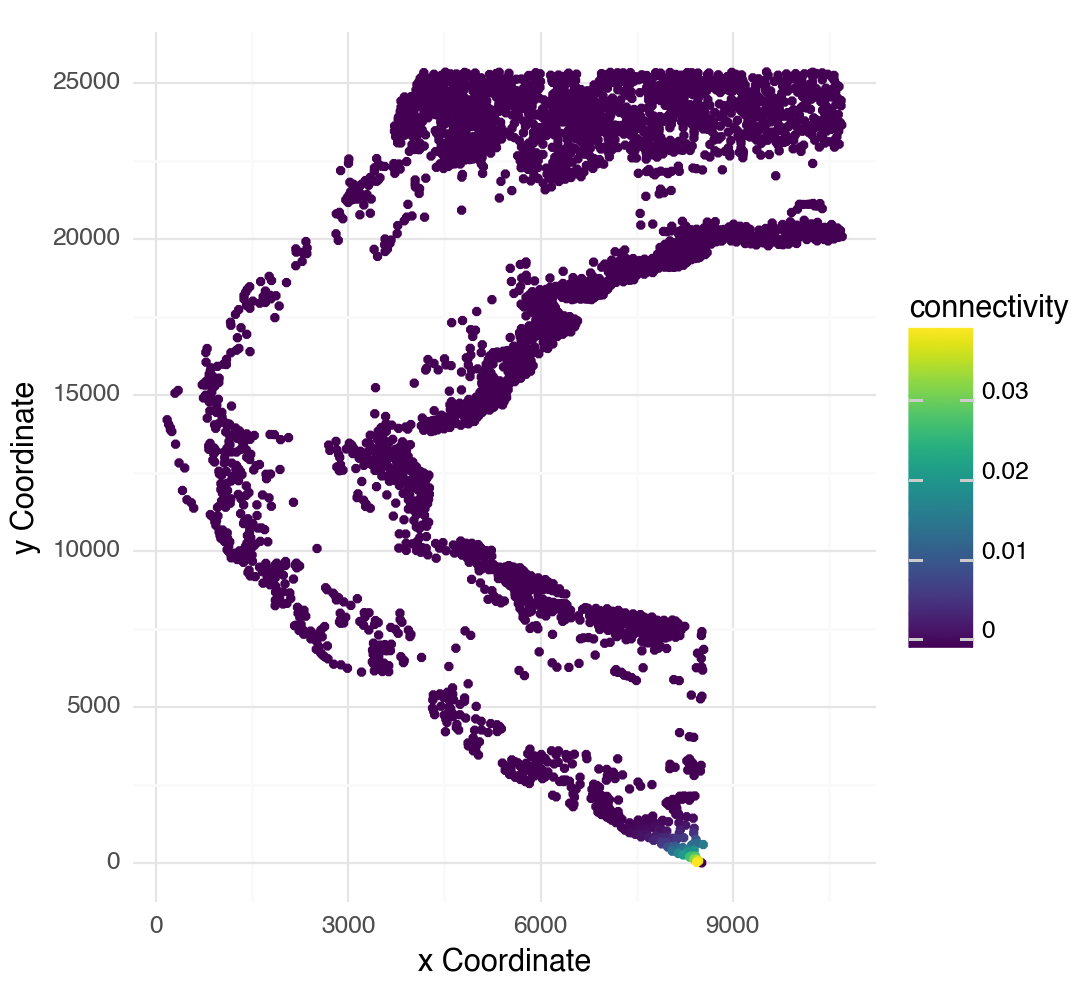

<Figure Size: (540 x 500)>

In [70]:
import pandas as pd
import squidpy as sq
import scanpy as sc
import liana as li
from itertools import product
from scipy.sparse import csr_matrix

sample = list(anndata_objects.keys())[1]
adata = anndata_objects[sample]
cell_type_names = adata.obs['anno_cell_type_lvl2'].unique()

onehot_ct = pd.get_dummies(adata.obs['anno_cell_type_lvl2']).astype(int)
#onehot_ct.columns = onehot_ct.columns.str.replace('', ' ')

combinations = list(product(onehot_ct.columns, repeat=2))
adata = sc.AnnData(X=csr_matrix(onehot_ct.values),
                var=pd.DataFrame(index=onehot_ct.columns),
                obs=adata.obs.copy(),
                obsm=adata.obsm.copy(),
                uns=adata.uns.copy(),)

li.ut.spatial_neighbors(adata, bandwidth=600, cutoff=0.01, kernel='gaussian', set_diag=False, standardize=True)
li.pl.connectivity(adata, idx=0, size=1)


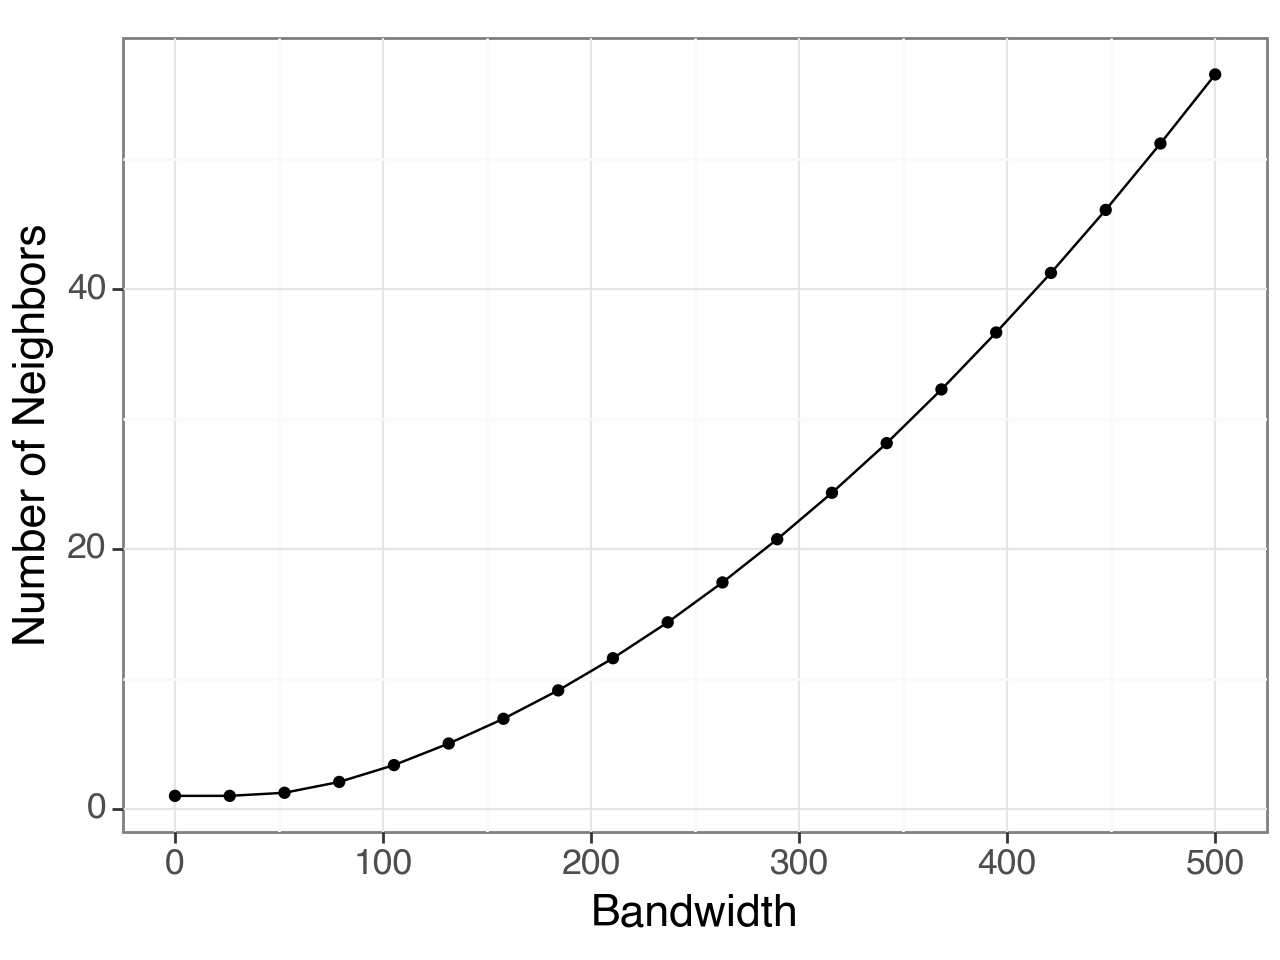

(<Figure Size: (640 x 480)>,
       bandwith  neighbours
 0     0.000000    1.000000
 1    26.315789    1.001958
 2    52.631579    1.237172
 3    78.947368    2.072072
 4   105.263158    3.366823
 5   131.578947    5.028006
 6   157.894737    6.932432
 7   184.210526    9.118096
 8   210.526316   11.591853
 9   236.842105   14.356052
 10  263.157895   17.423619
 11  289.473684   20.748727
 12  315.789474   24.323345
 13  342.105263   28.144144
 14  368.421053   32.276342
 15  394.736842   36.659616
 16  421.052632   41.242656
 17  447.368421   46.091461
 18  473.684211   51.200940
 19  500.000000   56.514101)

In [25]:
li.ut.query_bandwidth(adata.obsm['spatial'], start=0, end=500, interval_n=20)

... storing 'anno_cell_type_lvl1' as categorical
... storing 'anno_cell_type_lvl2' as categorical
... storing 'anno_cell_type_lvl3' as categorical


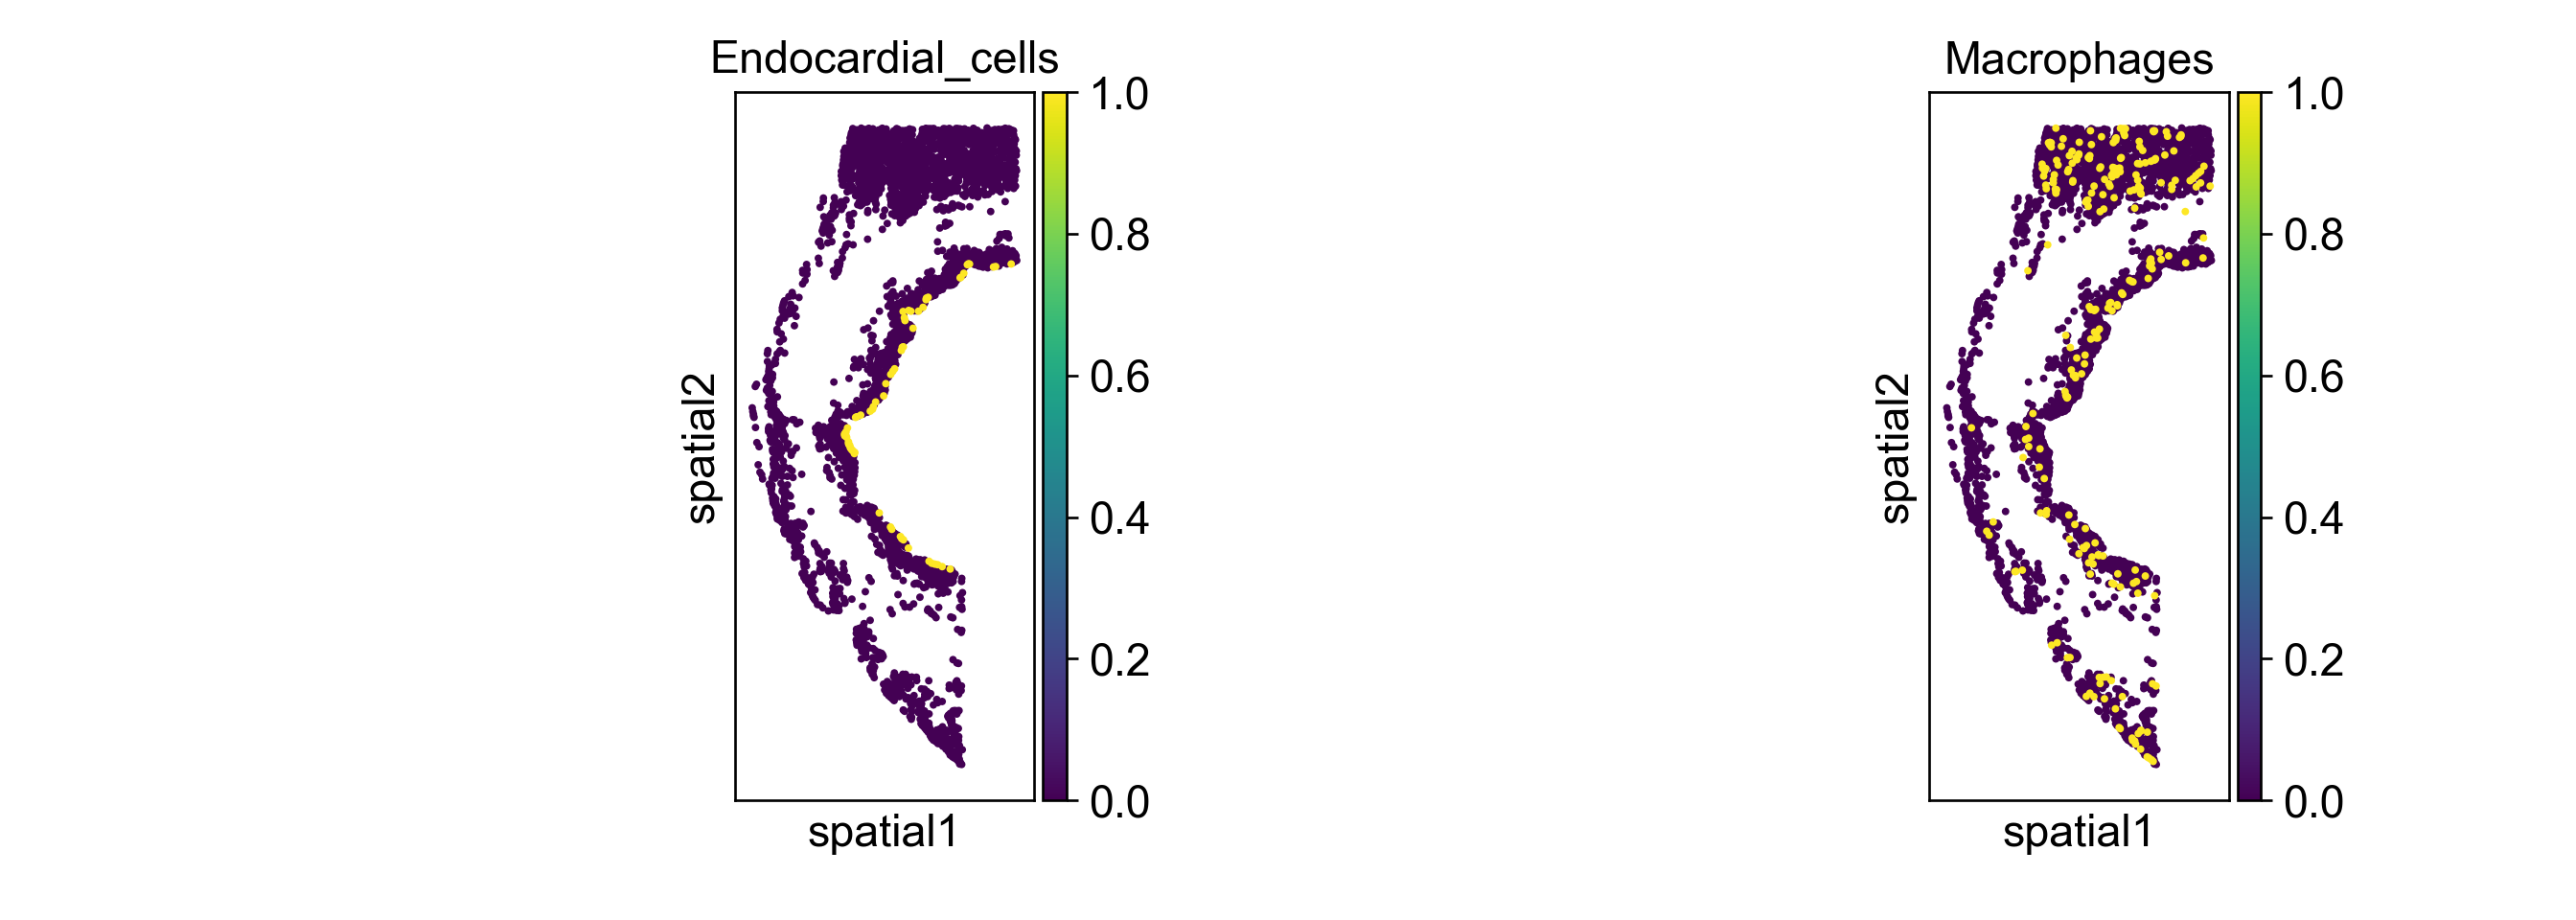

In [68]:
## Plot only two cell types for which we want to calculate interactions for visual inspection
#adata = anndata_objects['sample_4h_r1_s1']
sample = list(anndata_objects.keys())[1]
adata = anndata_objects[sample]
cell_type_names = adata.obs['anno_cell_type_lvl2'].unique()

onehot_ct = pd.get_dummies(adata.obs['anno_cell_type_lvl2']).astype(int)
#onehot_ct.columns = onehot_ct.columns.str.replace('', ' ')

combinations = list(product(onehot_ct.columns, repeat=2))
adata = sc.AnnData(X=csr_matrix(onehot_ct.values),
                var=pd.DataFrame(index=onehot_ct.columns),
                obs=adata.obs.copy(),
                obsm=adata.obsm.copy(),
                uns=adata.uns.copy(),)
sc.pl.spatial(adata, color=['Endocardial_cells','Macrophages'], spot_size = 300, wspace=0.4, ncols = 2)

In [71]:
li.mt.lr_bivar(adata,
            function_name='product', # Name of the function
            n_perms=10, # Number of permutations to calculate a p-value
            mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
            add_categories=True, # Whether to add local categories to the results
            expr_prop=0.01, # Minimum expr. proportion for ligands/receptors and their subunits
            use_raw=False,
            verbose=True,
            interactions = combinations
            )
lrdata = adata.obsm['local_scores']

Using provided `interactions`.
Using `.X`!
Make sure that normalized counts are passed!
['Cardiac_fibroblasts', 'Cardiomyocytes_Nppa+', 'Cardiomyocytes_Nppb+', 'Dendritic_cells', 'Endocardial_cells', 'Endothelial_cells', 'Lymphatic_endothelial_cells', 'Macrophages_Ccl2', 'Smooth_muscle_cells'] contain `_`. Consider replacing those!
Removing 14 self-interactions
100%|██████████| 10/10 [00:01<00:00,  9.34it/s]


In [72]:
lrdata.var.sort_values("global_mean", ascending=False).index

Index(['Cardiomyocytes^Cardiomyocytes_Nppa+',
       'Cardiomyocytes_Nppa+^Cardiomyocytes',
       'Cardiomyocytes_Nppa+^Cardiac_fibroblasts',
       'Cardiac_fibroblasts^Cardiomyocytes_Nppa+',
       'Cardiac_fibroblasts^Endothelial_cells',
       'Endothelial_cells^Cardiac_fibroblasts',
       'Cardiomyocytes_Nppa+^Endothelial_cells',
       'Endothelial_cells^Cardiomyocytes_Nppa+',
       'Cardiomyocytes^Endothelial_cells', 'Endothelial_cells^Cardiomyocytes',
       ...
       'Endocardial_cells^Pericytes', 'Pericytes^Endocardial_cells',
       'Endocardial_cells^Cardiomyocytes_Nppb+',
       'Cardiomyocytes_Nppb+^Endocardial_cells',
       'Lymphatic_endothelial_cells^Smooth_muscle_cells',
       'Smooth_muscle_cells^Lymphatic_endothelial_cells',
       'Endocardial_cells^Lymphatic_endothelial_cells',
       'Lymphatic_endothelial_cells^Endocardial_cells',
       'Endocardial_cells^Smooth_muscle_cells',
       'Smooth_muscle_cells^Endocardial_cells'],
      dtype='object', name='in

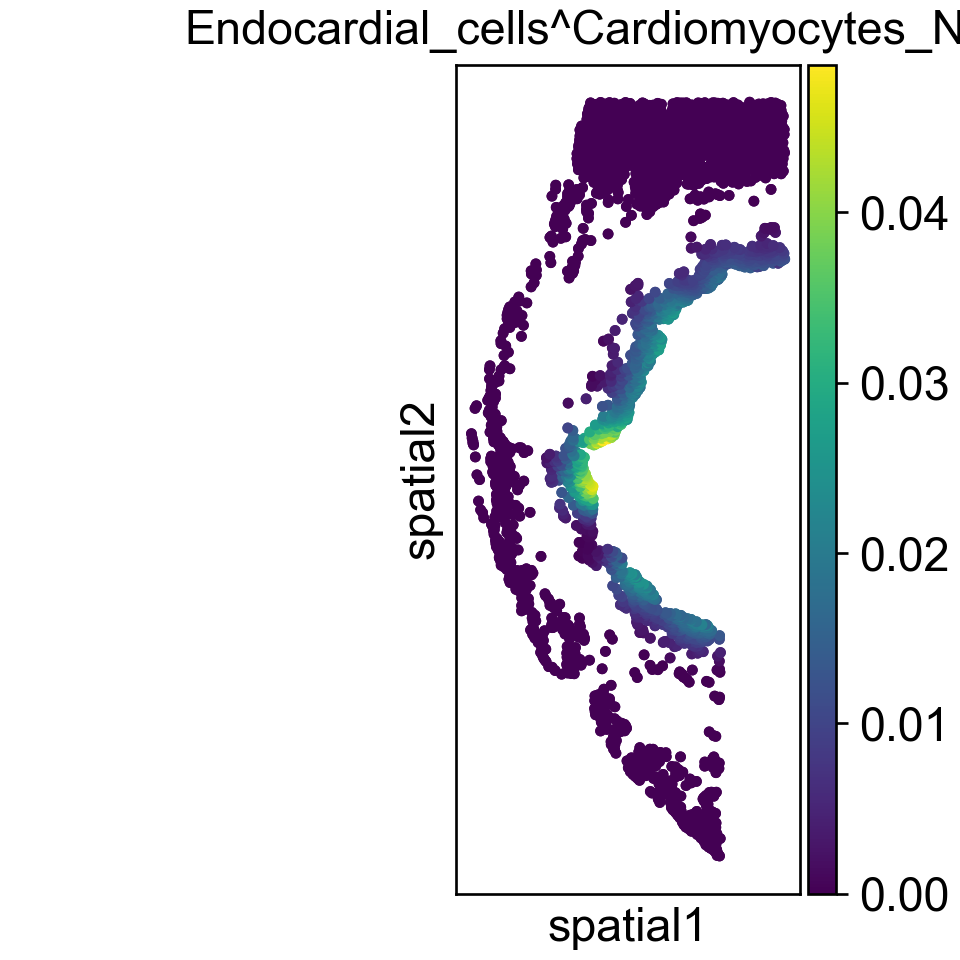

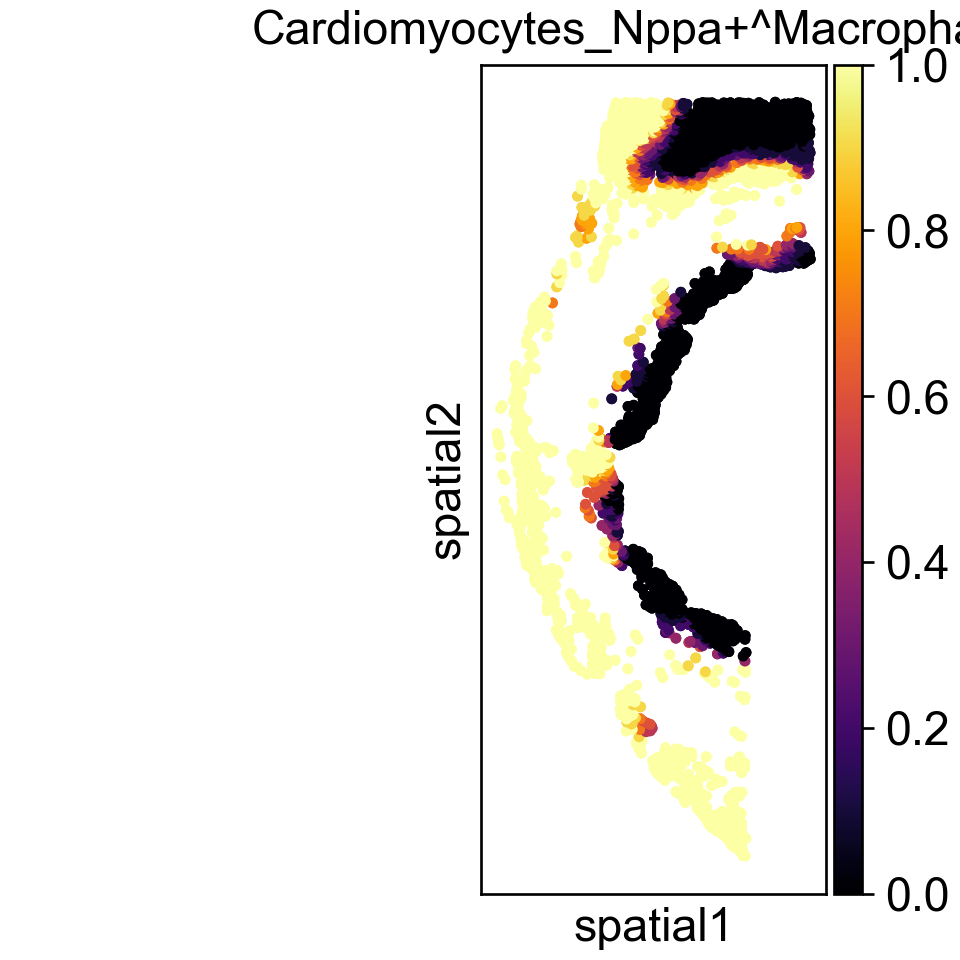

In [82]:
sq.pl.spatial_scatter(
    lrdata,
    library_id="spatial",
    color=[
        "Endocardial_cells^Cardiomyocytes_Nppa+",
    ],
    shape=None,
    size=20,
    img=False,
    layer=None,
    cmap="viridis"
)

sq.pl.spatial_scatter(
    lrdata,
    library_id="spatial",
    color=[
        "Cardiomyocytes_Nppa+^Macrophages",
    ],
    shape=None,
    size=20,
    img=False,
    layer="pvals",
    cmap="inferno",
)

plt.show()

In [73]:
lrdata.X
lrdata.layers['pvals']

<3688x156 sparse matrix of type '<class 'numpy.float64'>'
	with 470084 stored elements in Compressed Sparse Row format>

## Squidpy analysis

In [ ]:

## Perform Squidpy analysis for all samples and save plots and results
samples_to_run = ["sample_2d_r1_s1","sample_2d_r2_s1",
        "sample_control_r1_s1","sample_control_r2_s1"]
for sample in samples_to_run:
    print(sample)
    adata = anndata_objects[sample]

    ## Calculate spatial enrichment
    sq.gr.spatial_neighbors(adata, coord_type="generic",radius=800)
    adata.obs['anno_cell_type_lv2'] = adata.obs['anno_cell_type_lv2'].astype('category')
    sq.gr.nhood_enrichment(adata, cluster_key="anno_cell_type_lv2")
    sq.pl.nhood_enrichment(adata, cluster_key="anno_cell_type_lv2", method="ward", figsize=(5, 5), dpi = 300,
                           palette="tab20",
                           save=f'/Users/florian_wuennemann/1_Projects/MI_project/mi_spatialomics/plots/molkart.squidpy.nhood_enrichment_plot.{sample}.png')

    ## Calculate spatial co-occurence
    sq.gr.co_occurrence(adata, cluster_key="anno_cell_type_lv2")
    ## Cardiomyocytes_Nppa+
    try:
        sq.pl.co_occurrence(
            adata,
            cluster_key="anno_cell_type_lv2",
            clusters="Cardiomyocytes_Nppa+",
            figsize=(15, 10),
            palette="tab20",
            save = f'/Users/florian_wuennemann/1_Projects/MI_project/mi_spatialomics/plots/molkart.squidpy.co_occurrence_plot.CMs_Nppa.{sample}.png'
        )
    except Exception as e:
        print(f"An error occurred with sample {sample}: {e}")
    ## Myeloid cells
    try:
        sq.pl.co_occurrence(
            adata,
            cluster_key="anno_cell_type_lv2",
            clusters="Myeloid_cells",
            figsize=(15, 10),
            palette="tab20",
            save = f'/Users/florian_wuennemann/1_Projects/MI_project/mi_spatialomics/plots/molkart.squidpy.co_occurrence_plot.Myeloid_cells.{sample}.png'
        )
    except Exception as e:
        print(f"An error occurred with sample {sample}: {e}")
    ## Endocardial cells
    try:
        sq.pl.co_occurrence(
            adata,
            cluster_key="anno_cell_type_lv2",
            clusters="Endocardial_cell",
            figsize=(15, 10),
            palette="tab20",
            save = f'/Users/florian_wuennemann/1_Projects/MI_project/mi_spatialomics/plots/molkart.squidpy.co_occurrence_plot.Endocardial_cells.{sample}.png'
     )
    except Exception as e:
        print(f"An error occurred with sample {sample}: {e}")

## Liana Plus

In [ ]:
import pandas as pd
import scanpy as sc
import plotnine as p9
import decoupler as dc
import liana as li
import scanpy as sc
import squidpy as sq

from mudata import MuData

In [ ]:
from itertools import product
cell_type_names = adata.obs['anno_cell_type_lvl2'].unique()
combinations = list(product(cell_type_names, repeat=2))
combinations_list = list(combinations)
onehot_ct = pd.get_dummies(adata.obs['anno_cell_type_lvl2']).astype(int)
test = sc.AnnData(X=csr_matrix(onehot_ct),
                  var=pd.DataFrame(index=onehot_ct.columns),
                  obs=adata.obs.copy(),
                  obsm=adata.obsm.copy()
)
li.ut.spatial_neighbors(test, bandwidth=2000, cutoff=0.1, kernel='gaussian', set_diag=True)
li.pl.connectivity(test, idx=0, size=1.3)

li.mt.lr_bivar(test,
               function_name='jaccard', # Name of the function
               n_perms=100, # Number of permutations to calculate a p-value
               mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
               add_categories=True, # Whether to add local categories to the results
               expr_prop=0.01, # Minimum expr. proportion for ligands/receptors and their subunits
               use_raw=False,
               verbose=True,
               interactions = combinations_list)

Using provided `interactions`.
Using `.X`!
Make sure that normalized counts are passed!
['B_cells', 'Cardiac_fibroblasts', 'Cardiomyocytes_Nppa+', 'Cardiomyocytes_Nppb+', 'Cycling_cells', 'Dendritic_cells', 'Endocardial_cells', 'Endothelial_cells', 'Epicardial_cells', 'Glia_cells', 'Smooth_muscle_cells'] contain `_`. Consider replacing those!
Removing 15 self-interactions
 38%|███▊      | 38/100 [00:16<00:27,  2.27it/s]


KeyboardInterrupt: 

In [ ]:
li.pl.connectivity(test, idx=0, size=1.3)

AssertionError: 

In [ ]:
lrdata = test.obsm['local_scores']
lrdata.uns['global_res'].sort_values("global_mean", ascending=False)
#lrdata.uns['global_res'].sort_values("global_sd", ascending=False)
#sc.pl.spatial(lrdata, color=['Cardiomyocytes_Nppa+^Endocardial_cell'], vmax=1, spot_size = 150)

,interaction,ligand,ligand_means,ligand_props,receptor,receptor_means,receptor_props,global_mean,global_sd
0,Vascular_endothelium^Cardiomyocytes,Vascular_endothelium,0.286628,0.286622,Cardiomyocytes,0.413959,0.413925,0.0,0.0
84,Cardiomyocytes_Nppa+^EndMA+,Cardiomyocytes_Nppa+,0.064794,0.064795,EndMA+,0.013658,0.013658,0.0,0.0
82,Pericytes^EndMA+,Pericytes,0.024266,0.024266,EndMA+,0.013658,0.013658,0.0,0.0
81,Cardiomyocytes^EndMA+,Cardiomyocytes,0.413959,0.413925,EndMA+,0.013658,0.013658,0.0,0.0
80,Vascular_endothelium^EndMA+,Vascular_endothelium,0.286628,0.286622,EndMA+,0.013658,0.013658,0.0,0.0
...,...,...,...,...,...,...,...,...,...
31,Cardiomyocytes^Cardiomyocytes_Nppa+,Cardiomyocytes,0.413959,0.413925,Cardiomyocytes_Nppa+,0.064794,0.064795,0.0,0.0
30,Vascular_endothelium^Cardiomyocytes_Nppa+,Vascular_endothelium,0.286628,0.286622,Cardiomyocytes_Nppa+,0.064794,0.064795,0.0,0.0
29,Smooth_muscle_cells^Cardiomyocytes_Nppb+,Smooth_muscle_cells,0.013404,0.013404,Cardiomyocytes_Nppb+,0.074259,0.074260,0.0,0.0
28,EndMA+^Cardiomyocytes_Nppb+,EndMA+,0.013658,0.013658,Cardiomyocytes_Nppb+,0.074259,0.074260,0.0,0.0


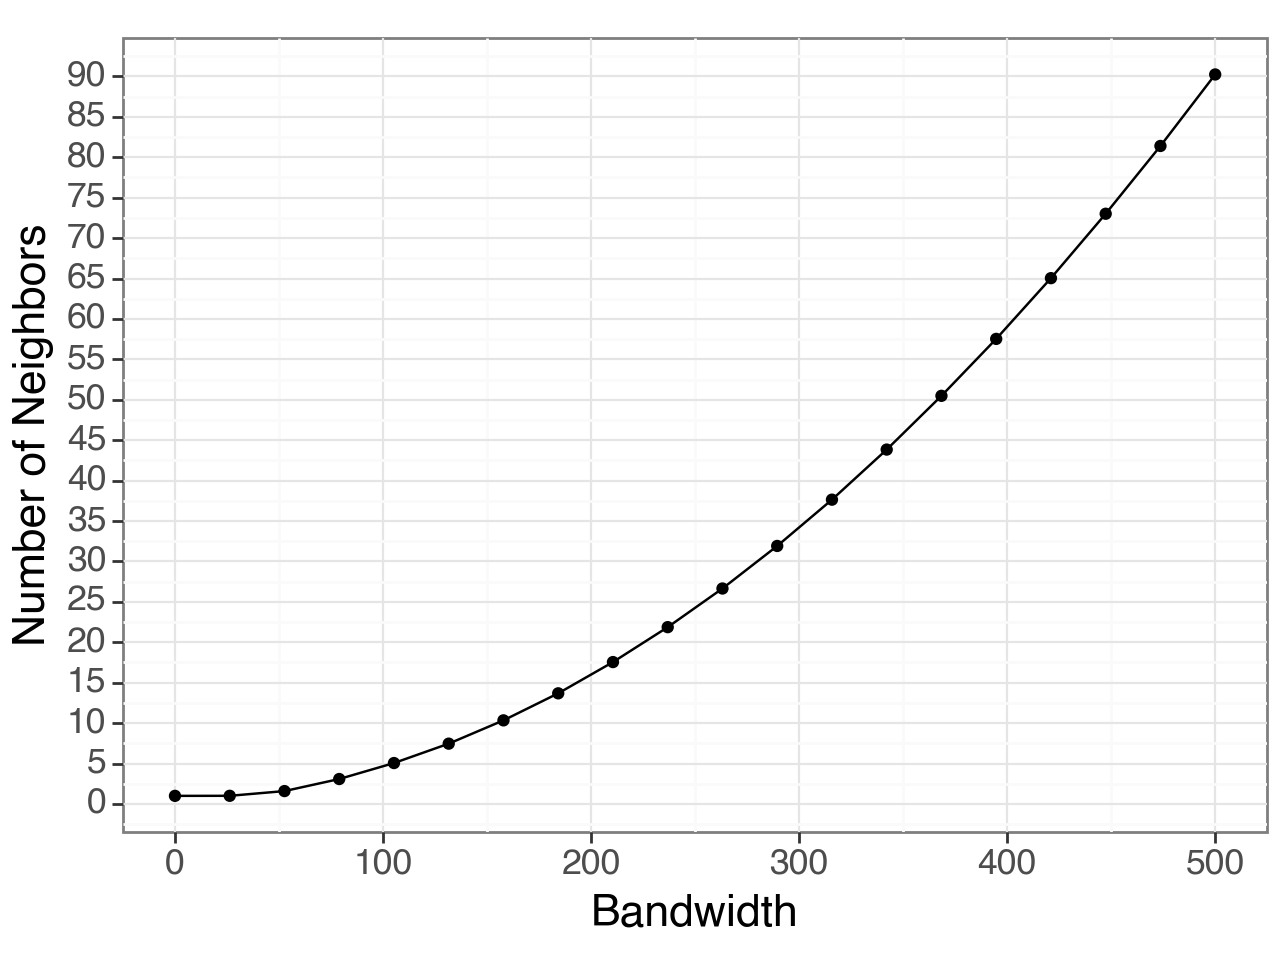

<Figure Size: (640 x 480)>

In [ ]:
plot, _ = li.ut.query_bandwidth(coordinates=test.obsm['spatial'], start=0, end=500, interval_n=20)
plot + p9.scale_y_continuous(breaks=range(0, 500, 5))

In [ ]:
test.write('/Users/florian_wuennemann/Downloads/florian_test.lianaplus.h5ad')

... storing 'anno_cell_type_lvl1' as categorical
... storing 'anno_cell_type_lv2' as categorical
... storing 'anno_cell_type_lvl3' as categorical


In [134]:
li.__version__

'1.0.4'